<a href="https://colab.research.google.com/github/felipepenha/data-science-bits/blob/master/performance_metrics/ROC_top_mistakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [3]:
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
# %%% SEABORN PLOT CONFIGURATION %%%%
# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

# References:
#  [1] https://stackoverflow.com/questions/55746749/latex-equations-do-not-render-in-google-colaboratory-when-using-matplotlib
#  [2] https://learnsharewithdp.wordpress.com/2020/05/08/latex-matplotlib-google-colab/

! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm/type1cm.sty #7
! sudo texhash #8
! apt install cm-super #9

import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

from pprint import pprint

! pip freeze | grep 'matplotlib\|seaborn'

# References: 
# [1] https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# [2] https://seaborn.pydata.org/tutorial/aesthetics.html
# [3] https://github.com/mwaskom/seaborn/blob/master/seaborn/rcmod.py

rc_base = {}

rc_font_size_base = {
    # --- FONT SIZE ---         
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.titlesize': 14,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'legend.title_fontsize': 11,
    'axes.linewidth': 1.25,
    'grid.linewidth': 1,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'patch.linewidth': 1,
    'xtick.major.width': 1.25,
    'ytick.major.width': 1.25,
    'xtick.minor.width': 1,
    'ytick.minor.width': 1,
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'xtick.minor.size': 3,
    'ytick.minor.size': 3,
}

font_scaling = 1.5

rc_font_size_scaled = {
    k: str(int(v * font_scaling)) 
    for k, v in rc_font_size_base.items()
    }

rc_custom = {**rc_base, **rc_font_size_scaled}

pprint(rc_custom)

sns.set_style('ticks')

sns.set_context('paper', rc=rc_custom)

# --- LATEX FONTS ---
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Computer Modern'
matplotlib.rcParams['mathtext.fontset'] = 'cm'

matplotlib.rcParams['mathtext.fallback_to_cm'] = True
matplotlib.rcParams['axes.formatter.use_mathtext'] = True

matplotlib.rcParams['text.latex.preamble'] = r'\usepackage{amsmath, amssymb}'

# --- TICKS ---
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  libpotrace0 libptexenc1 libsynctex1 libtexlua52 libtexluajit2 libzzip-0-13
  lmodern poppler-data t1utils tex-common texlive-base texlive-binaries
  texlive-latex-base
Suggested packages:
  fonts-noto poppler-utils ghostscript fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum debhelper gv
  | postscript-viewer perl-tk xpdf-reader | pdf-viewer texlive-latex-base-doc
  texlive-latex-recommended-doc texlive-pstricks
The following NEW packages will be installed:
  fonts-droid-fallback fonts-lmodern fonts-noto-mono libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 libkpathsea6
  lib

# Generate Data, Split, and Fit

In [4]:
# Generate some data to play with
X, y = datasets.make_classification(
    n_samples=500,
    n_features=20,
    n_informative=2,
    n_redundant=2
    )

# Binarize the output
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = (
    train_test_split(
      X,
      y,
      test_size=.25,
      random_state=42
      )
)

# Learn to predict each class against the other
classifier = RandomForestClassifier(random_state=42)

classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

# ROC - Right Way


In [5]:
def plot_roc(fpr, tpr, file_name, legend_loc='lower right'):

  # Area Under the Curve (AUC)
  roc_auc = auc(fpr, tpr)

  plt.figure(figsize=(8, 6))

  # ROC Curve
  plt.plot(fpr, tpr, color='darkorange',
          lw=3, label='ROC curve (AUC = %0.2f)' % roc_auc)

  # Diagonal Line
  plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

  # Scatter Plot
  plt.scatter(fpr, tpr, s=30, zorder=3, color='navy')

  plt.xlim([-0.025, 1.025])

  plt.ylim([-0.025, 1.025])

  plt.xlabel('False Positive Rate')

  plt.ylabel('True Positive Rate')

  plt.legend(loc=legend_loc)

  plt.tight_layout(.5);

  plt.savefig(
      '{}.png'.format(file_name),
      transparent=True,
      dpi=300
      )
  
  plt.show()

  pass

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


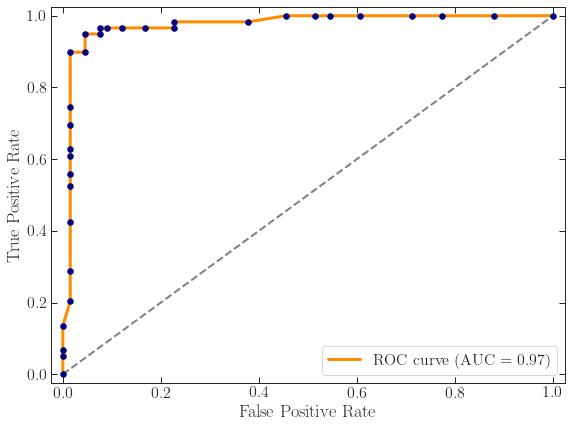

In [6]:
pred_test = np.transpose(classifier.predict_proba(X_test))[1]

fpr, tpr, _ = roc_curve(y_test, pred_test)

plot_roc(fpr, tpr, 'ROC_correct')

# ROC - Wrong Way

## [1] Using predicted classes (default threshold at 0.5) instead of the output probability

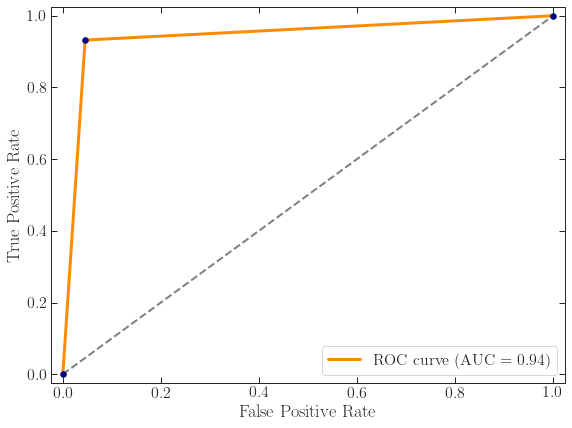

In [7]:
pred_test = classifier.predict(X_test)

fpr, tpr, _ = roc_curve(y_test, pred_test)

plot_roc(fpr, tpr, 'ROC_top_1_mistake')

## [2] Using the wrong outuput probability

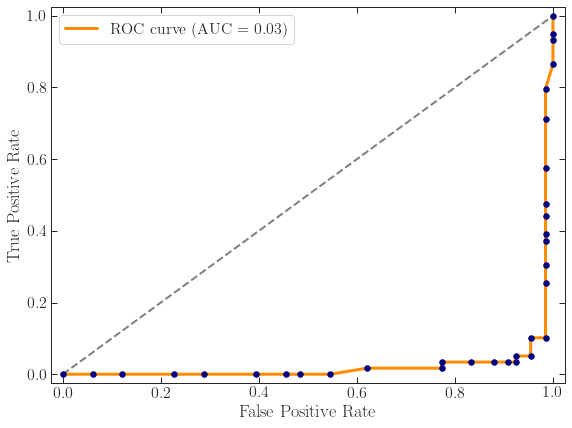

In [8]:
pred_test = pred_test = np.transpose(classifier.predict_proba(X_test))[0]

fpr, tpr, _ = roc_curve(y_test, pred_test)

plot_roc(fpr, tpr, 'ROC_top_2_mistake', legend_loc='upper left')